In [1]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

Mounted at /content/drive


In [2]:
# 2. Đọc file csv
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FinalProject_BA/NVL Historical Data 1_6.csv')

In [3]:
df['Price'] = df['Price'].str.replace('$', '', regex=True)
df['Price'] = df['Price'].str.replace(',', '', regex=True)
df['Price'] = df.Price.astype(float)
df['Date'] = pd.to_datetime(df['Date'])
df=df[::-1]
df1=df.reset_index()['Price']

In [4]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [5]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(len(df1)) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [6]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [7]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

# time_step = 100
# X_train, y_train = create_dataset(train_data, time_step)
# X_test, ytest = create_dataset(test_data, time_step)
time_step = 100

x, y = create_dataset(df1, time_step)

X_train = x[:train_size-100]
X_test = x[train_size-100:]
y_train = y[:train_size-100]
ytest = y[train_size-100:]

In [8]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [9]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [10]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
16/16 [==============================] - 7s 195ms/step - loss: 0.0610 - val_loss: 0.0400
Epoch 2/100
16/16 [==============================] - 1s 62ms/step - loss: 0.0106 - val_loss: 0.0105
Epoch 3/100
16/16 [==============================] - 1s 60ms/step - loss: 0.0043 - val_loss: 0.0070
Epoch 4/100
16/16 [==============================] - 1s 59ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 5/100
16/16 [==============================] - 1s 58ms/step - loss: 5.4814e-04 - val_loss: 9.5717e-04
Epoch 6/100
16/16 [==============================] - 1s 59ms/step - loss: 3.2017e-04 - val_loss: 6.9489e-04
Epoch 7/100
16/16 [==============================] - 1s 92ms/step - loss: 3.0682e-04 - val_loss: 6.2543e-04
Epoch 8/100
16/16 [==============================] - 1s 62ms/step - loss: 2.9764e-04 - val_loss: 6.3923e-04
Epoch 9/100
16/16 [==============================] - 1s 59ms/step - loss: 2.9261e-04 - val_loss: 6.2163e-04
Epoch 10/100
16/16 [==============================] - 1s 59

In [11]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

15/15 [==============================] - 0s 14ms/step


In [12]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [13]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

Testing RMSE: 37825.30563581393


In [14]:
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_pred, ytest)
test_mape = np.mean(np.abs(y_pred - ytest)/np.abs(y_pred))*100
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing MAPE: 99.99880259190135
Testing MAE: 28286.373954838527


In [15]:
x_input = test_data[len(test_data)-time_step:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = 100
i = 0
while(i < 90):

    if(len(temp_input) > 100):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1

print(lst_output)


[[0.04710117727518082], [0.04605906829237938], [0.044875286519527435], [0.043635353446006775], [0.04235566034913063], [0.04104423522949219], [0.03970608115196228], [0.03834418207406998], [0.03696028143167496], [0.0355553962290287], [0.03413009271025658], [0.032684676349163055], [0.03121926449239254], [0.029733890667557716], [0.028228528797626495], [0.026703067123889923], [0.025157354772090912], [0.02359125390648842], [0.02200457453727722], [0.020397115498781204], [0.018768668174743652], [0.017119018360972404], [0.01544793602079153], [0.013755186460912228], [0.012040539644658566], [0.010303749702870846], [0.00854457262903452], [0.0067627620883286], [0.004958074539899826], [0.003130247350782156], [0.0012790414039045572], [-0.0005958075635135174], [-0.0024945519398897886], [-0.004417449235916138], [-0.006364758126437664], [-0.008336737751960754], [-0.010333647020161152], [-0.012355747632682323], [-0.014403299428522587], [-0.016476565971970558], [-0.01857580803334713], [-0.0207012891769409

In [16]:
future_predict = scaler.inverse_transform(np.array(lst_output).reshape(-1, 1))
future_predict

array([[14117.76027313],
       [14032.1864519 ],
       [13934.97902784],
       [13833.16068357],
       [13728.07740523],
       [13620.3884201 ],
       [13510.50455987],
       [13398.67085519],
       [13285.03047004],
       [13169.66691674],
       [13052.626693  ],
       [12933.93488309],
       [12813.60112306],
       [12691.62816606],
       [12568.01387075],
       [12442.74905995],
       [12315.82134447],
       [12187.21940579],
       [12056.9276427 ],
       [11924.9295363 ],
       [11791.20795584],
       [11655.74531173],
       [11518.52271428],
       [11379.52089142],
       [11238.72095346],
       [11096.1027106 ],
       [10951.64612601],
       [10805.33097165],
       [10657.13724892],
       [10507.04339146],
       [10355.02976392],
       [10201.07466611],
       [10045.1573729 ],
       [ 9887.25673854],
       [ 9727.35152169],
       [ 9565.42044276],
       [ 9401.44224129],
       [ 9235.39542739],
       [ 9067.25866413],
       [ 8897.01030865],


In [17]:
# Append the last 100 values of test_data to the beginning of y_pred
last_100_test_data = scaler.inverse_transform(test_data[:101])
y_pred_with_test_data = np.append(last_100_test_data, y_pred)

In [18]:
print(y_pred_with_test_data.shape)
test_data.shape

(580,)


(480, 1)

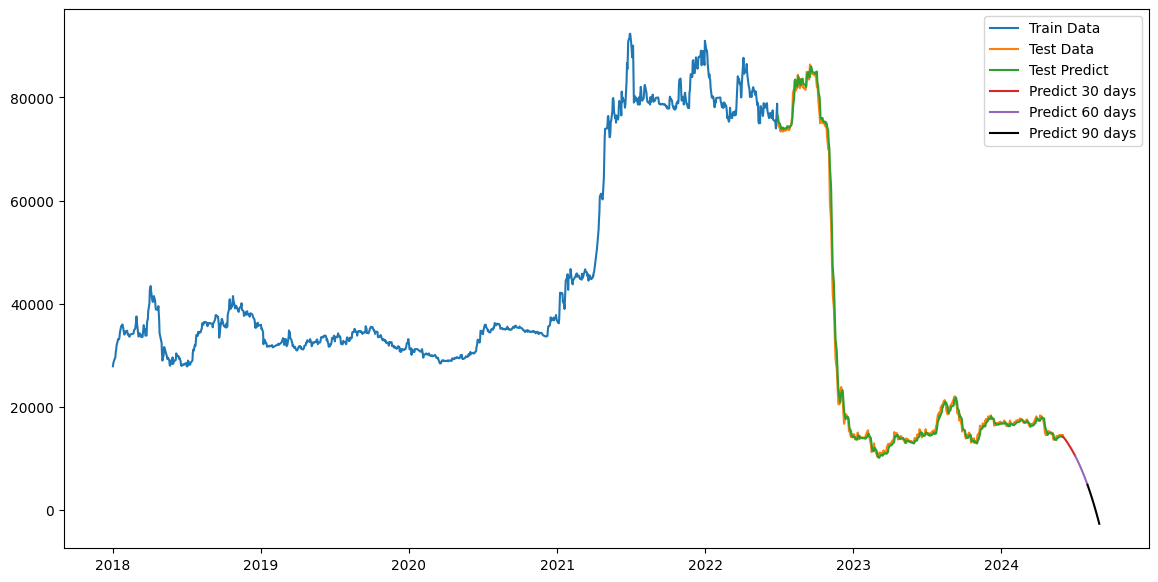

In [20]:
# Plot results
plt.figure(figsize=(14, 7))

# Plot train data
plt.plot(df['Date'][:train_size], scaler.inverse_transform(train_data), label='Train Data')

# Plot test data
plt.plot(df['Date'][train_size:], scaler.inverse_transform(test_data), label='Test Data')

# Plot test predict data with appended last 100 test data
plt.plot(df['Date'][train_size:train_size + len(y_pred)], y_pred, label='Test Predict')

# Plot future predictions
last_test_date = df['Date'].iloc[-1]
future_predict_dates = pd.date_range(start=last_test_date + pd.Timedelta(days=1), periods=30)
future_predict_dates_1 = pd.date_range(start=last_test_date + pd.Timedelta(days=31), periods=30)
future_predict_dates_2 = pd.date_range(start=last_test_date + pd.Timedelta(days=61), periods=30)

plt.plot(future_predict_dates, future_predict[0:30], label='Predict 30 days')
plt.plot(future_predict_dates_1, future_predict[30:60], label='Predict 60 days')
plt.plot(future_predict_dates_2, future_predict[60:90], label='Predict 90 days', color='black')
# Display the legend
plt.legend()

# Display the plot
plt.show()